In [22]:
%pylab inline
import radvel

import corner
import copy

from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    xlabel('Time')
    ylabel('RV')
    draw()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Intialize Keplerian model parameters
====================================

In [23]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

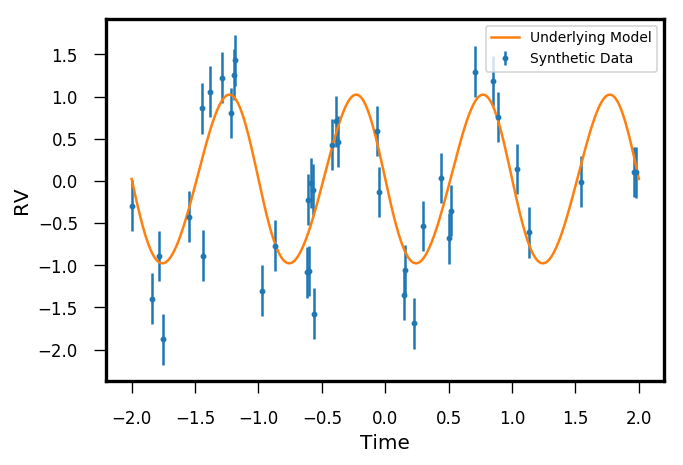

In [24]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + randn(t.size)*np.sqrt(errvel**2 + jitter**2)
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,rv_mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [25]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


Perform a maximum likelihood fit
===============================

 final_simplex: (array([[ 1.00649141, -0.03556684,  0.275805  ,  0.30159039,  1.23514078,
         0.05884145, -0.01486154, -0.04165493],
       [ 1.00648937, -0.03555464,  0.27577307,  0.30155931,  1.23504742,
         0.05883754, -0.01486101, -0.04165094],
       [ 1.00649232, -0.03557108,  0.2758309 ,  0.30166718,  1.23507679,
         0.0588678 , -0.01486941, -0.04167205],
       [ 1.00648667, -0.03556411,  0.27578173,  0.30159803,  1.23508396,
         0.05885339, -0.01486599, -0.04166079],
       [ 1.0064951 , -0.03557768,  0.27587591,  0.30162117,  1.23511611,
         0.05883103, -0.01485636, -0.04165243],
       [ 1.00648076, -0.03555186,  0.27576705,  0.30156084,  1.2350599 ,
         0.05884061, -0.01486222, -0.04165237],
       [ 1.00648871, -0.03556267,  0.2758306 ,  0.3015759 ,  1.23507842,
         0.05882527, -0.01485564, -0.04164659],
       [ 1.00648732, -0.03556148,  0.27577496,  0.30161293,  1.23513235,
         0.05886212, -0.01486903, -0.04166569],
       [ 1.0064

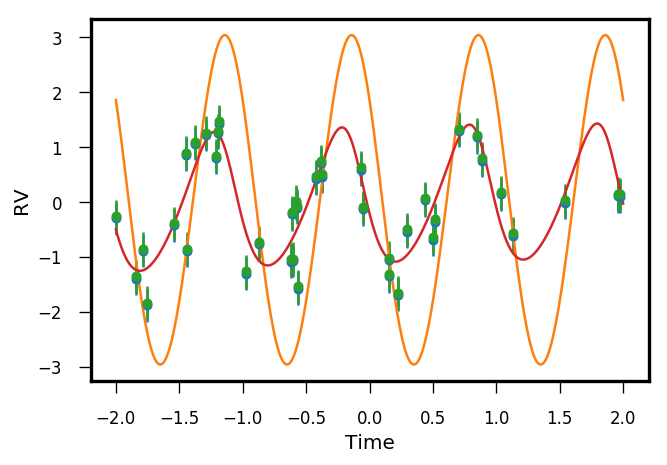

In [26]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Instantiate a posterior object
===============================

In [27]:
post = radvel.posterior.Posterior(like_syn)
post.params.update(dict(per1=radvel.Parameter(value=1),
                        k1=radvel.Parameter(value=1)))
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post.priors)
print(post)

[e1 constrained to be < 0.99, Gaussian prior on jit, mu=0.3, sigma=0.1, Gaussian prior on per1, mu=1, sigma=0.1, Gaussian prior on tc1, mu=0, sigma=0.1, secondary eclipse constraint: 0.5 +/- 0.01]
parameter                     value      vary
per1                              1       True
tc1                      -0.0355681       True
secosw1                    0.275794       True
sesinw1                    0.301582       True
k1                                1       True
dvdt                      0.0588414       True
curv                     -0.0148618       True
gamma                    -0.0416544       True
jit                             0.3       True

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



Perform maximum likelihood fit on posterior
=========================================

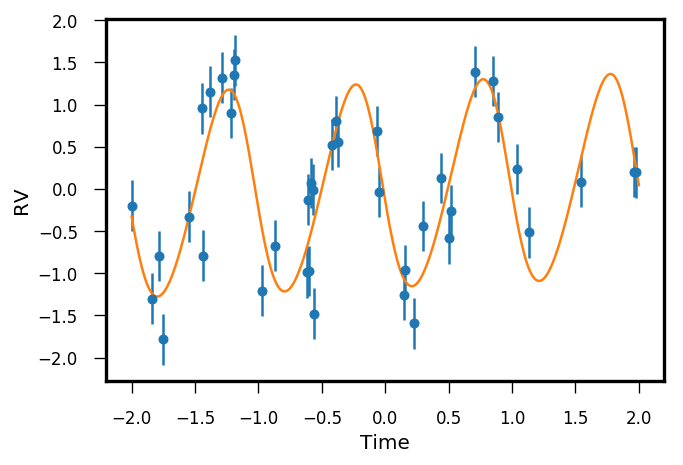

In [28]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [29]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

8000/160000 (5.0%) steps complete; Running 9393.85 steps/s; Mean acceptance rate = 46.7%; Min Tz = 1489.9; Max G-R = 1.02      
Discarding burn-in now that the chains are marginally well-mixed


Chains are well-mixed after 120000 steps! MCMC completed in 14.7 seconds




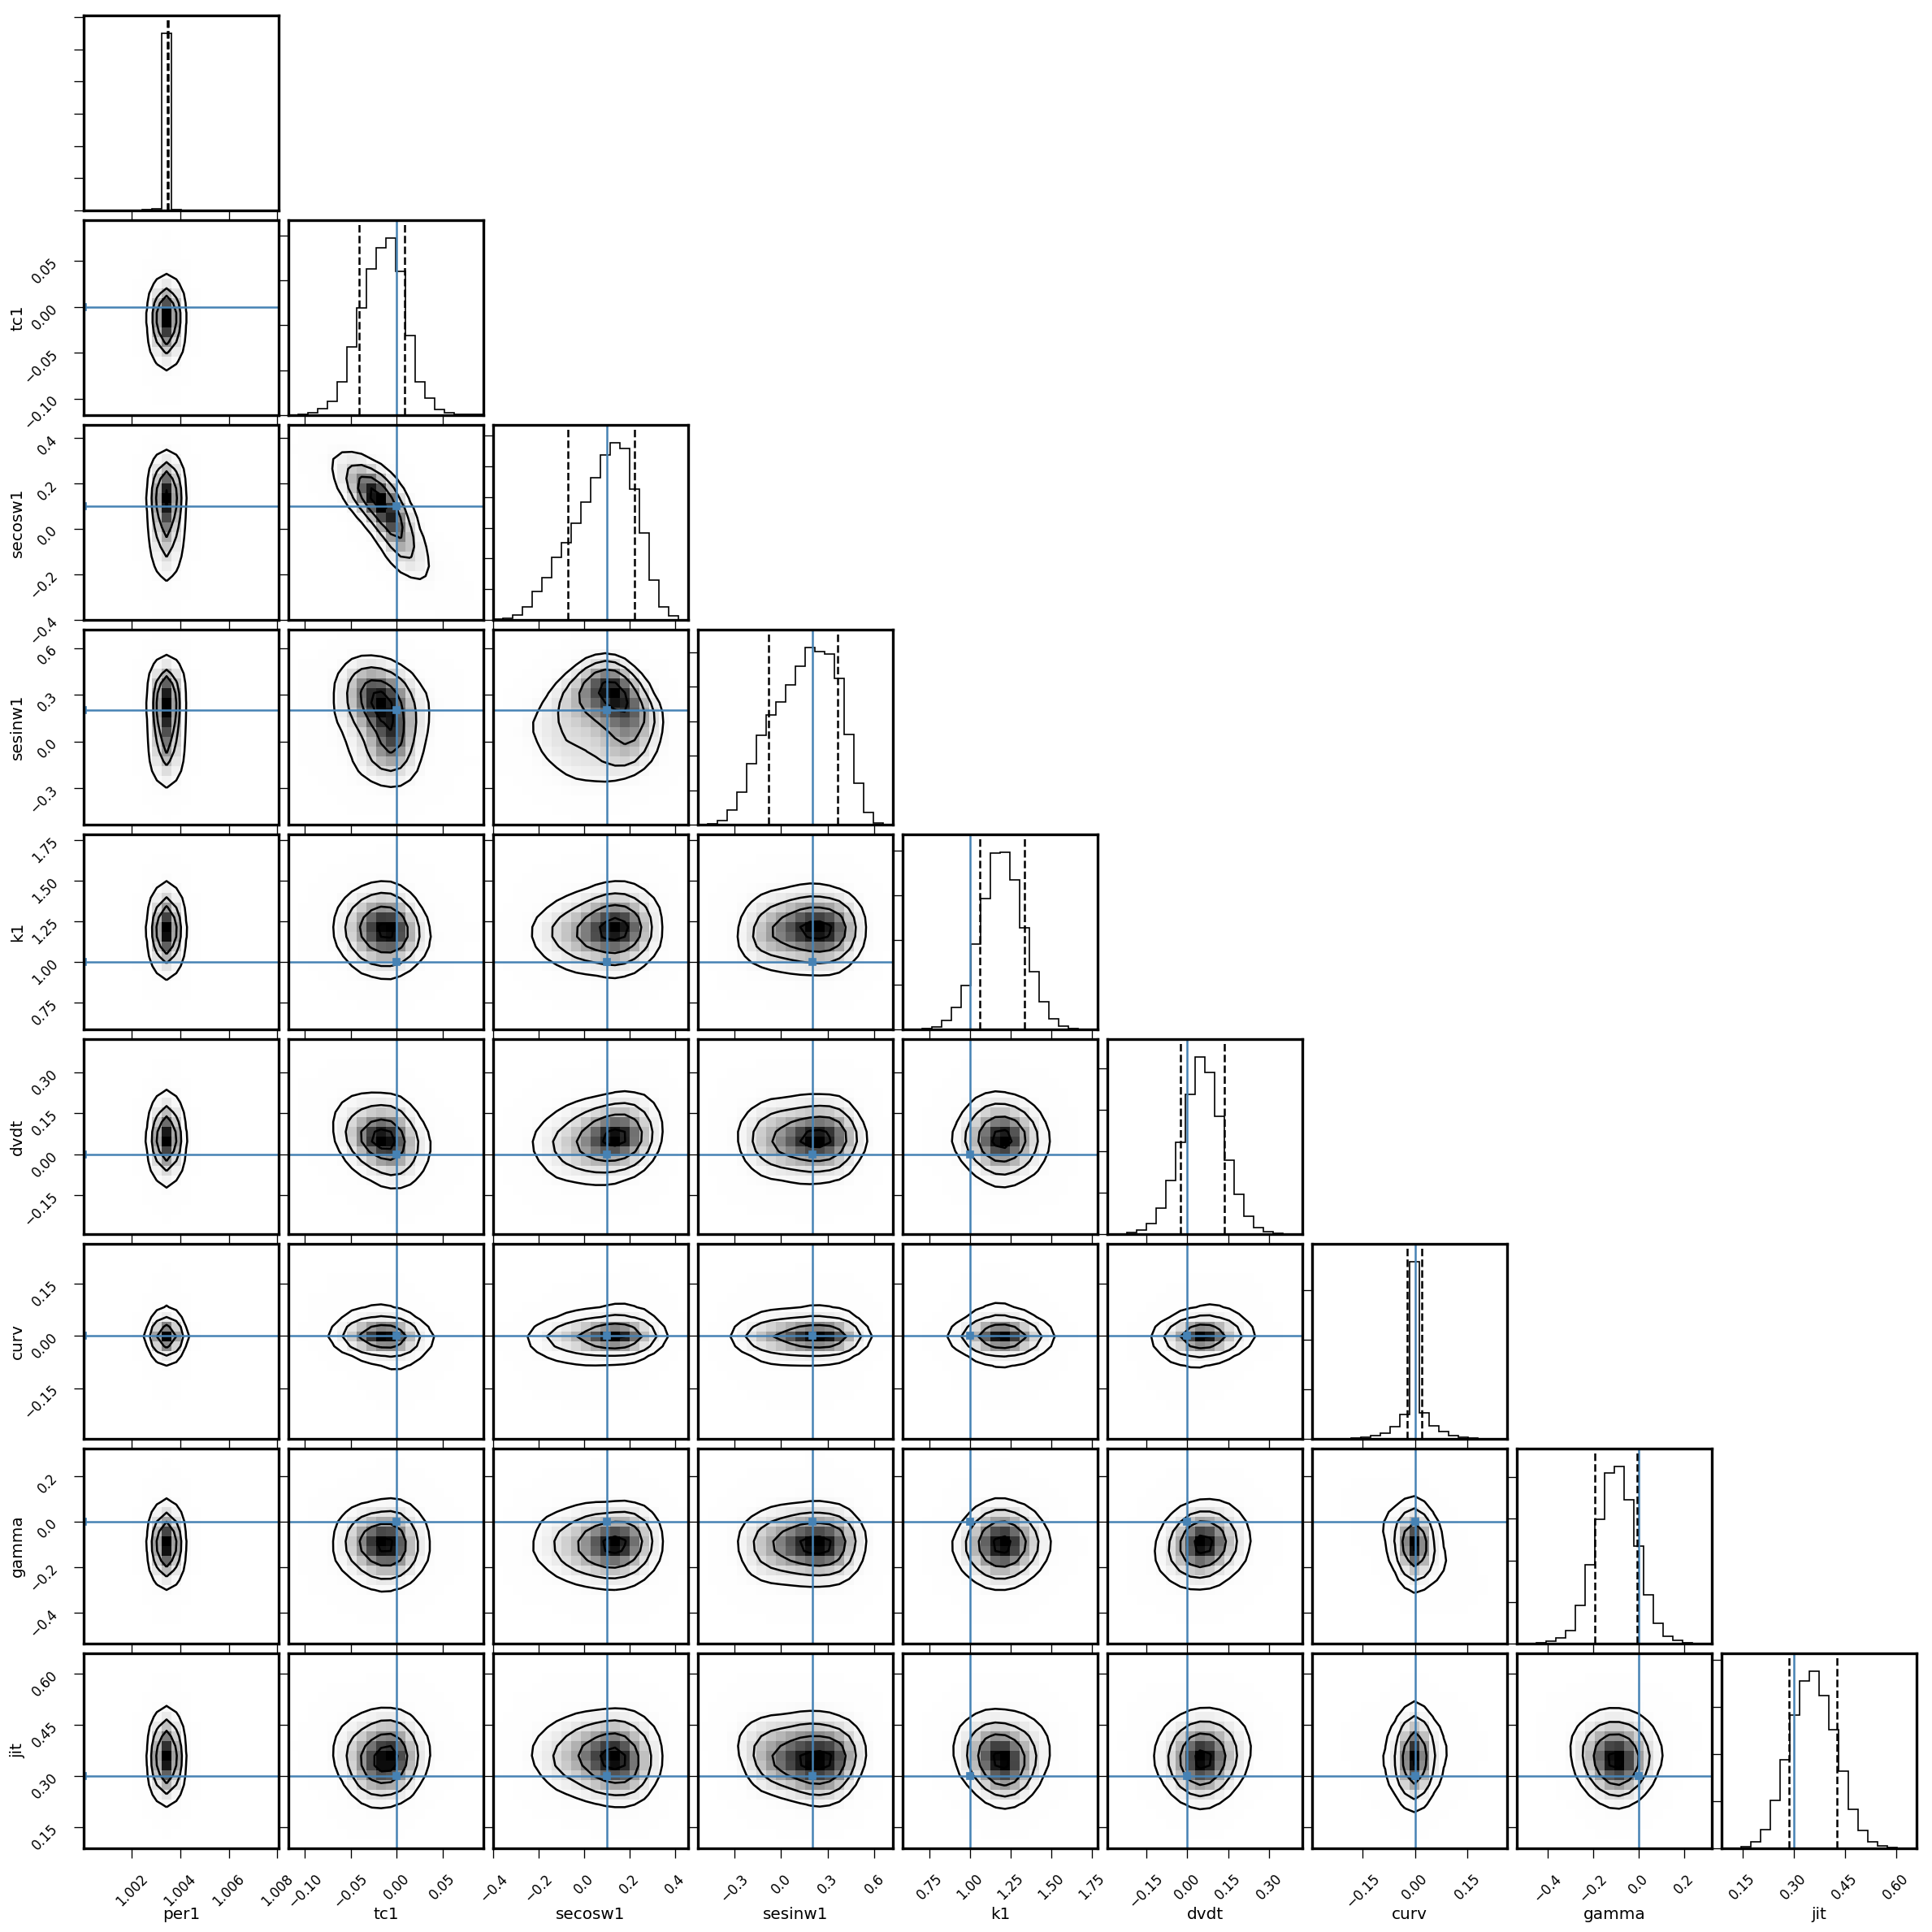

In [30]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

(array([  2.60000000e+01,   7.50000000e+01,   2.13000000e+02,
          6.87000000e+02,   2.55800000e+03,   7.40100000e+03,
          1.75930000e+04,   3.48540000e+04,   3.73620000e+04,
          1.12310000e+04]),
 array([-42.91996193, -41.11363267, -39.3073034 , -37.50097414,
        -35.69464487, -33.88831561, -32.08198634, -30.27565708,
        -28.46932781, -26.66299855, -24.85666928]),
 <a list of 10 Patch objects>)

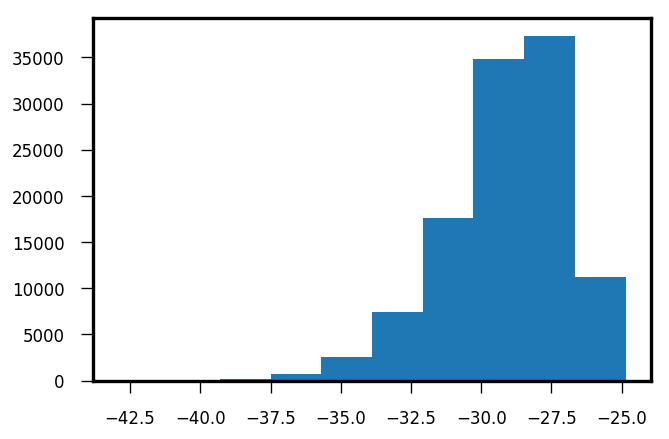

In [31]:
hist(df.lnprobability)